# Analyse des données du Poker Hand Dataset

Ce notebook présente une analyse et une classification des données du Poker Hand Dataset. Nous allons suivre les étapes suivantes :

**0. Analyse des données** :  
**1. Prétraitement des données** : Séparation en ensembles d'entraînement et de test.  
**2. Entraînement et évaluation d'un modèle random forest** : Utilisation d'une random forest sans tuning et évaluation.  
**3. Étude des poids donnés à chaque classe** : Étude de la performance des modèles en fonction du poids des différentes classes.  
**4. Fine-tuning des hyperparamètres** : Optimisation des hyperparamètres du modèle MLP à l'aide de GridSearch.  
**5. Analyse des résultats** : Discussion des performances du modèle et des améliorations possibles.  

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score
import itertools
from ucimlrepo import fetch_ucirepo 

Matplotlib is building the font cache; this may take a moment.


In [14]:
# fetch dataset 
poker_hand = fetch_ucirepo(id=158) 
  
# data (as pandas dataframes) 
X = poker_hand.data.features 
y = poker_hand.data.targets 
  
# metadata 
print(poker_hand.metadata) 
  
# variable information 
print(poker_hand.variables)

# Define class names for evaluation report
class_names = {
    0: "Nothing in hand",
    1: "One pair",
    2: "Two pairs",
    3: "Three of a kind",
    4: "Straight",
    5: "Flush",
    6: "Full house",
    7: "Four of a kind",
    8: "Straight flush",
    9: "Royal flush"
}



DatasetNotFoundError: Error reading data csv file for "Poker Hand" dataset (id=158).

In [15]:
training_data = pd.read_csv("/Users/ronan/Projet ML/poker+hand/poker-hand-training-true.data")
testing_data = pd.read_csv("/Users/ronan/Projet ML/poker+hand/poker-hand-testing.data")

# Prepare your feature set (X) and labels (y)
X = testing_data.iloc[:, :-1]  # All columns except the last one
y = testing_data.iloc[:, -1]     # The last column (hand class)

# Define class names for evaluation report
class_names = {
    0: "Nothing in hand",
    1: "One pair",
    2: "Two pairs",
    3: "Three of a kind",
    4: "Straight",
    5: "Flush",
    6: "Full house",
    7: "Four of a kind",
    8: "Straight flush",
    9: "Royal flush"
}

### 0.Analyse des données

-----
### Poker Hand Dataset

The dataset used in this notebook is the Poker Hand dataset from the UCI Machine Learning Repository. The purpose of this dataset is to predict poker hands. It contains 1,025,010 instances with 10 features representing the suit and rank of five playing cards.

### Quick Exploratory Data Analysis (EDA)

We will start with a quick exploratory data analysis to understand the distribution of the target variable and the features. This will help us gain insights into the dataset before proceeding with model training and evaluation.

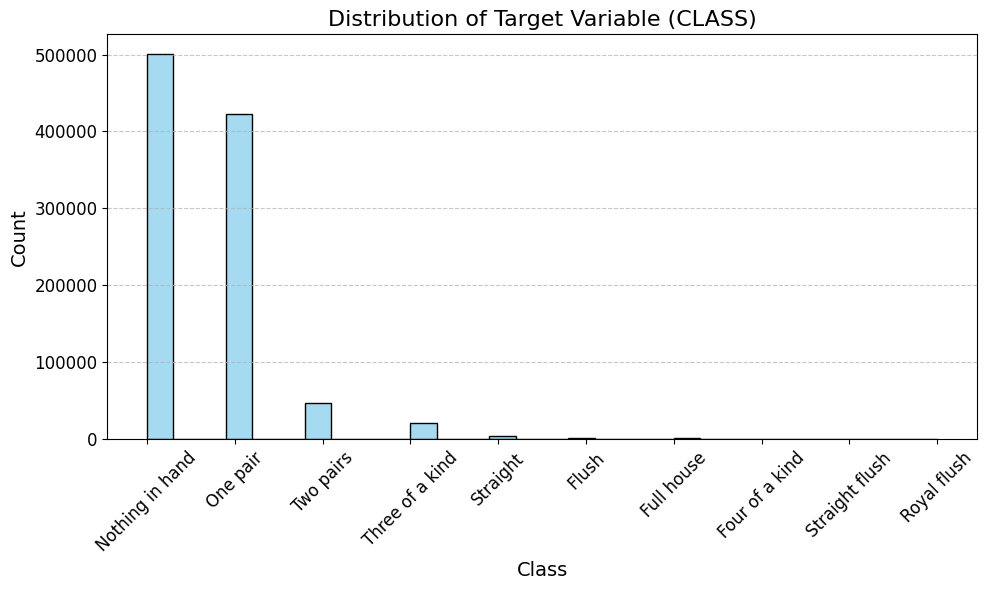

In [22]:
# Plot the distribution of the target variable y
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=False, color='skyblue', edgecolor='black')  # Just use y directly
plt.title('Distribution of Target Variable (CLASS)', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=range(10), labels=[class_names[i] for i in range(10)], rotation=45, fontsize=12)  # Apply class names to x-axis
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Percentage Distribution of Poker Hand Values:
0
0    50.120850
1    42.249842
2     4.762205
3     2.112102
4     0.388500
5     0.199600
6     0.142400
7     0.023000
8     0.001200
9     0.000300
Name: proportion, dtype: float64
Distribution of Poker Hand Values:
0
0    501208
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: count, dtype: int64


/var/folders/t1/3h8kh00s1zj6t6fz6sc864600000gn/T/ipykernel_63786/853970079.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[class_names[i] for i in value_counts_percentage.index], y=value_counts_percentage.values, palette='viridis')


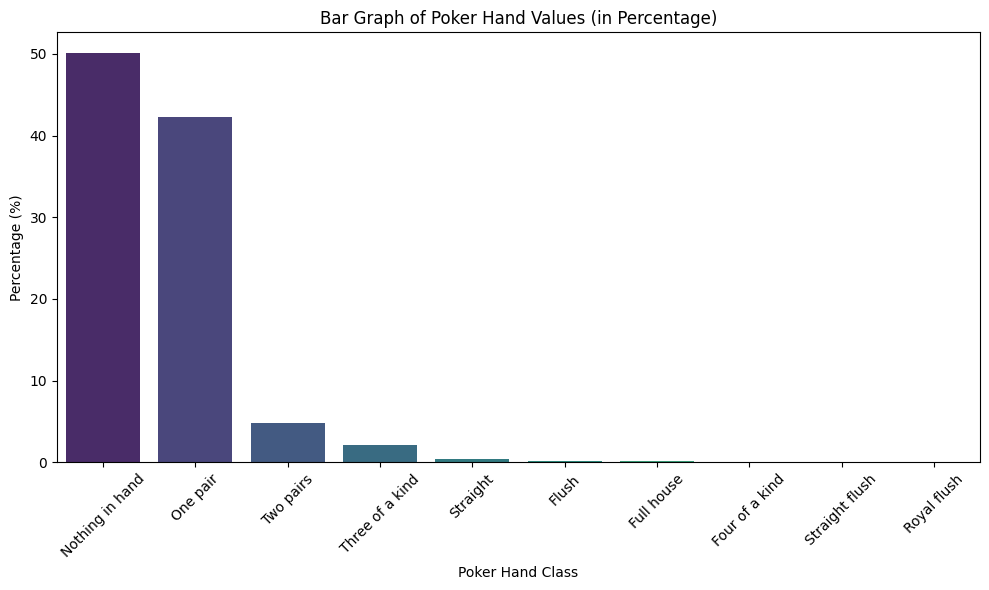

In [23]:
# Extract the value_of_hand column from the DataFrame
value_of_hand = y  

# Create a count of each unique value in the value_of_hand column and normalize to get percentages
value_counts_percentage = value_of_hand.value_counts(normalize=True) * 100
value_counts = value_of_hand.value_counts()

# Print the table with the percentages
print("Percentage Distribution of Poker Hand Values:")
print(value_counts_percentage)

# Print the table in absolute values
print("Distribution of Poker Hand Values:")
print(value_counts)

# Plotting the bar graph with percentages
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[i] for i in value_counts_percentage.index], y=value_counts_percentage.values, palette='viridis')

# Add labels and title
plt.xlabel('Poker Hand Class')
plt.ylabel('Percentage (%)')
plt.title('Bar Graph of Poker Hand Values (in Percentage)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the bar graph
plt.tight_layout()
plt.show()


### 1.Prétraitement des données

---

- **Séparation en training, validation et test** : on sépare la donnée entre le jeu d'entraînement, de validation et d'évaluation finale

- **Distribution des classes** : Il est nécessaire que les classes soient identiquement distribuées afin que le modèle dispose de suffisament de données d'entraînement pour chaque classe

In [26]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution in the training set
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

Training set class distribution:
0
0    0.501208
1    0.422498
2    0.047623
3    0.021121
4    0.003885
5    0.001996
6    0.001424
7    0.000230
8    0.000013
9    0.000003
Name: proportion, dtype: float64


### 2.Entraînement et évaluation d'un modèle random forest

---

- **Random Forest** : Dans cette partie, nous utiliserons une random forest avec des paramètres choisis arbitrairement: nombre d'estimateurs=100, random_state=42

- **Evaluation** 

In [29]:
# Initialize and fit the Random Forest model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X_train, y_train)

# Optional: Check the representation of each hand class in the training set
print("Number of samples per class in the training set:")
print(y_train.value_counts())

Number of samples per class in the training set:
0
0    400966
1    337998
2     38098
3     16897
4      3108
5      1597
6      1139
7       184
8        10
9         2
Name: count, dtype: int64


In [30]:
y_pred = model1.predict(X_test)
print(f"Accuracy: {model1.score(X_test, y_test)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

Accuracy: 0.751985
              precision    recall  f1-score   support

           0       0.77      0.91      0.84    100242
           1       0.72      0.69      0.71     84500
           2       0.64      0.03      0.06      9524
           3       0.85      0.08      0.15      4224
           4       0.47      0.01      0.02       777
           5       0.99      0.19      0.32       399
           6       0.64      0.02      0.05       285
           7       0.00      0.00      0.00        46
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1

    accuracy                           0.75    200000
   macro avg       0.51      0.19      0.21    200000
weighted avg       0.75      0.75      0.72    200000



/Users/ronan/Projet ML/DAML_poker_hand/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ronan/Projet ML/DAML_poker_hand/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ronan/Projet ML/DAML_poker_hand/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

we realize we have an overall precision of 0.75, but the less the class is represented in the dataset, the lower the precision is. (except for class 5)

### 3. Étude des poids donnés à chaque classe : Étude de la performance des modèles en fonction du poids des différentes classes.  
---
- **Duplication of data** : For the less represented data, we'll duplicate the line of the class [2,9] so we have more sample in the training  and testing set.

- **Grid search** : Evaluate the evolution of the precision based on the weight given to all the classes.

In [35]:
# Filter for indices in y where the class is 3 or higher
indices_to_duplicate = y[y >= 2].index

# Duplicate the rows in X and y at the selected indices
X_duplicated = pd.concat([X.loc[indices_to_duplicate]] * 2, ignore_index=True)
y_duplicated = pd.concat([y.loc[indices_to_duplicate]] * 2, ignore_index=True)

# Combine the original X and y with the duplicated rows
X_duplicated_lines = pd.concat([X, X_duplicated], ignore_index=True)
y_duplicated_lines = pd.concat([y, y_duplicated], ignore_index=True)


Let's redo a random forest and evaluate it.

In [36]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_duplicated_lines, y_duplicated_lines, test_size=0.2, random_state=42, stratify=y_duplicated_lines
)

# Initialize and fit the Random Forest model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X_train, y_train)

# Check the representation of each hand class in the training set
print("Number of samples per class in the training set:")
print(y_train.value_counts())

y_pred = model1.predict(X_test)
print(f"Accuracy: {model1.score(X_test, y_test)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

Number of samples per class in the training set:
0
0    400966
1    337999
2    114293
3     50690
4      9324
5      4790
6      3418
7       552
8        29
9         7
Name: count, dtype: int64
Accuracy: 0.8525618501021617
              precision    recall  f1-score   support

           0       0.79      0.93      0.85    100242
           1       0.87      0.70      0.78     84499
           2       0.97      0.96      0.97     28573
           3       0.99      0.97      0.98     12673
           4       0.99      0.96      0.97      2331
           5       1.00      0.95      0.98      1198
           6       1.00      0.95      0.98       854
           7       1.00      0.98      0.99       138
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         2

    accuracy                           0.85    230517
   macro avg       0.96      0.94      0.95    230517
weighted avg       0.86      0.85      0.85    230517



We now have a precision very good for all the classes [2:9]<br><br>

Let's study the evolution of the precision based on the weight applied to the class 2 to 9.

In [44]:
def evaluate_class_weights(X, y, weight_range, test_size=0.2, random_state=42):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Store results for plotting or further analysis
    global_precision = []
    class_precisions = {i: [] for i in range(2, 10)}  # Dictionary for storing precision for classes 2-9
    
    # Iterate over different weight combinations for classes 2 to 9
    for weight in weight_range:
        # Define class weights (Other classes will be assigned a weight of 1)
        class_weights = {i: 1 for i in range(10)}  # Start by assigning all weights as 1
        for i in range(2, 10):  # Apply the variable weight for classes 2 to 9
            class_weights[i] = weight
        
        # Initialize the Random Forest model with class weights
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate global precision (macro average)
        global_prec = precision_score(y_test, y_pred, average='macro')  # Global precision (macro-average)
        
        # Calculate precision for each class (2 to 9)
        for i in range(2, 10):
            class_prec = precision_score(y_test, y_pred, average=None)[i]  # Precision for class i
            class_precisions[i].append(class_prec)
        
        # Store the global precision
        global_precision.append(global_prec)
    
    # Create a DataFrame to print results as a table
    results = pd.DataFrame({
        'Weight': weight_range,
        'Global Precision': global_precision,
        **{f'Class {i} Precision': class_precisions[i] for i in range(2, 10)}
    })
    
    # Print the table
    print(results)
    
    return global_precision, class_precisions

# Example usage with weight range
weight_range = np.linspace(1, 5, 5)

# Run the function above
global_prec, class_precisions = evaluate_class_weights(X, y, weight_range)

/Users/ronan/Projet ML/DAML_poker_hand/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ronan/Projet ML/DAML_poker_hand/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ronan/Projet ML/DAML_poker_hand/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

   Weight  Global Precision  Class 2 Precision  Class 3 Precision  \
0     1.0          0.507975           0.642702           0.849148   
1     2.0          0.541512           0.666667           0.844789   
2     3.0          0.539440           0.650155           0.820225   
3     4.0          0.540760           0.678311           0.801887   
4     5.0          0.531403           0.650456           0.827715   

   Class 4 Precision  Class 5 Precision  Class 6 Precision  Class 7 Precision  \
0           0.470588           0.987013           0.636364                0.0   
1           0.700000           0.977778           0.700000                0.0   
2           0.666667           1.000000           0.727273                0.0   
3           0.689655           1.000000           0.700000                0.0   
4           0.666667           1.000000           0.636364                0.0   

   Class 8 Precision  Class 9 Precision  
0                0.0                0.0  
1             

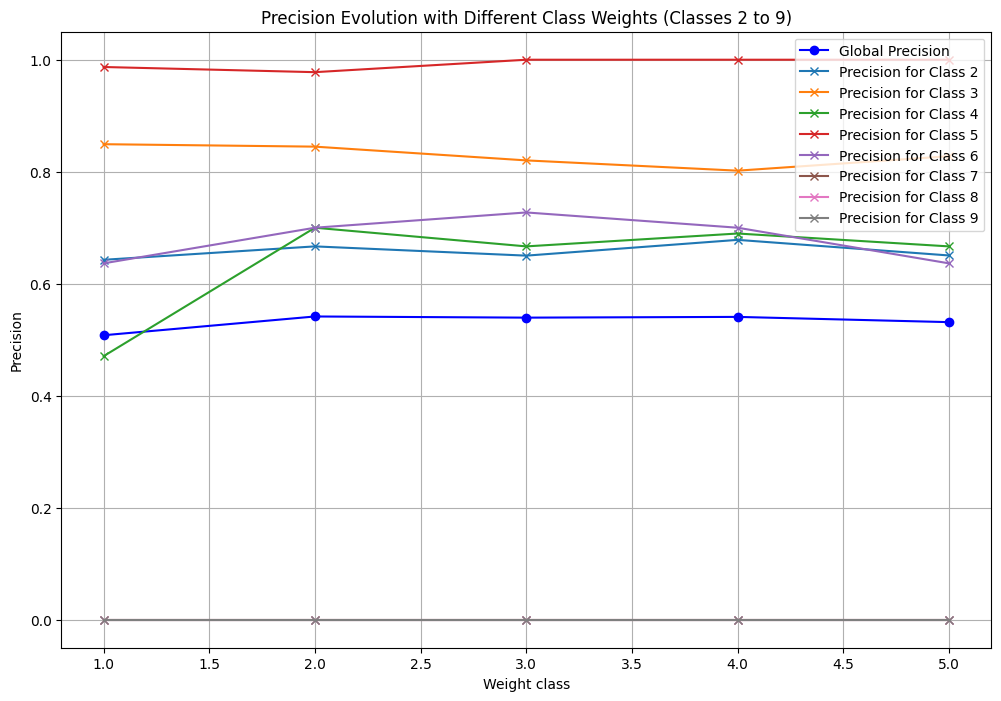

In [48]:
# Plotting the results
plt.figure(figsize=(12, 8))

# Plotting global precision
plt.plot(weight_range, global_prec, label='Global Precision', color='blue', marker='o')

# Plotting precision for each class (2 to 9)
for i in range(2, 10):
    plt.plot(weight_range, class_precisions[i], label=f'Precision for Class {i}', marker='x')

plt.title("Precision Evolution with Different Class Weights (Classes 2 to 9)")
plt.xlabel("Weight class")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

Etrangement, en augmentant le poids nous n'arrivons pas a obtenir une précision telle que lorsque nous avons dupliqué les lignes des classes 2 à 9. Cela peut s'expliquer de l mnière suivante:

Dupliquer les lignes (comme en répétant les échantillons des classes sous-représentées) fonctionne efficacement car cela augmente directement la fréquence de ces classes dans l'ensemble d'entraînement. Cela permet au modèle de voir davantage d'exemples des classes sous-représentées, ce qui améliore sa capacité à reconnaître et à prédire ces classes. Essentiellement, cela offre au modèle plus d'exposition aux motifs associés à ces classes, ce qui l'aide à faire de meilleures prédictions lorsque ces classes apparaissent dans l'ensemble de test.

En revanche, simplement ajouter des poids aux classes ne modifie pas directement la fréquence des exemples dans le jeu de données. Bien que l'attribution de poids aux classes incite le modèle à accorder plus d'attention aux classes sous-représentées en rendant les erreurs de classification pour ces classes plus "coûteuses", cela n'augmente pas nécessairement le nombre d'exemples que le modèle peut apprendre. Si le modèle n'a pas vu suffisamment d'exemples d'une classe, augmenter le poids de cette classe ne va pas améliorer substantiellement la précision, car le modèle aura toujours du mal avec la sous-représentation et les exemples limités. Par conséquent, la duplication des données augmente la représentation d'une classe, ce qui peut fournir des signaux d'apprentissage plus précieux au modèle par rapport au simple ajout de poids aux classes.

### Après cette étude, nous allons selectionner le dataset avec les lignes des classes 2 à 9 dupliquées.

### 4.Fine-tuning des hyperparamètres

Essayons de modifier les hyperparamètres de notre random forest à l'aide d'une recherche de type `GridSearch`. Nous allons en particulier nous intéresser aux paramètres suivants :

- n_estimators
- max_depth
- min_samples_leaf

In [ ]:
# Rewrite X and Y

# Filter for indices in y where the class is 3 or higher
indices_to_duplicate = y[y >= 2].index

# Duplicate the rows in X and y at the selected indices
X_duplicated = pd.concat([X.loc[indices_to_duplicate]] * 2, ignore_index=True)
y_duplicated = pd.concat([y.loc[indices_to_duplicate]] * 2, ignore_index=True)

# Combine the original X and y with the duplicated rows
X_duplicated_lines = pd.concat([X, X_duplicated], ignore_index=True)
y_duplicated_lines = pd.concat([y, y_duplicated], ignore_index=True)

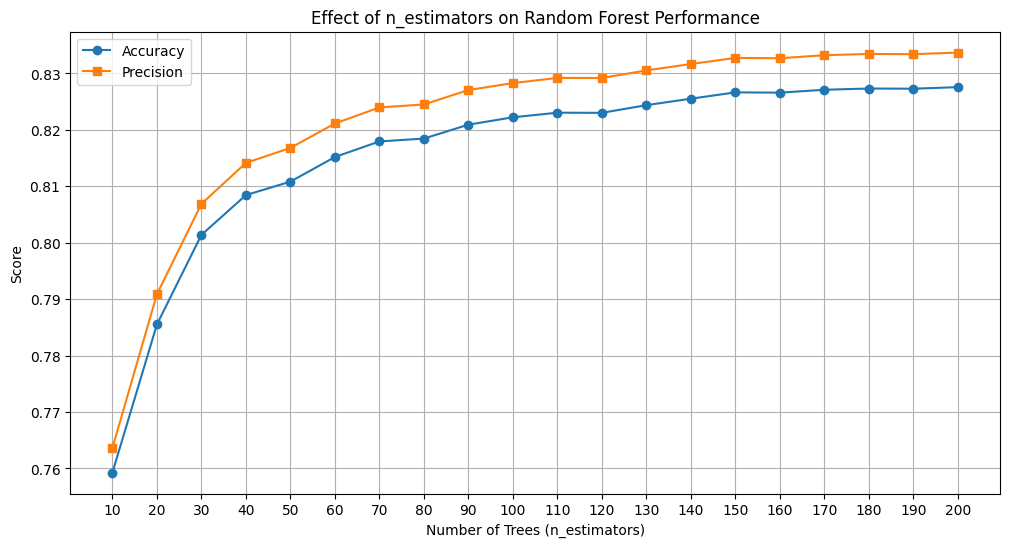

In [6]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X_duplicated_lines, y_duplicated_lines, test_size=0.2, random_state=42, stratify=y_duplicated_lines)

# Prepare to store results
n_estimators_range = range(10, 201, 10)  # From 10 to 200 with a step of 10
accuracy_results = []
precision_results = []

# Loop over the different values of n_estimators
for n in n_estimators_range:
    # Initialize and fit the Random Forest model
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Change to 'macro' if needed
    
    # Append results
    accuracy_results.append(accuracy)
    precision_results.append(precision)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, accuracy_results, label='Accuracy', marker='o')
plt.plot(n_estimators_range, precision_results, label='Precision', marker='s')
plt.title('Effect of n_estimators on Random Forest Performance')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Score')
plt.xticks(n_estimators_range)
plt.legend()
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

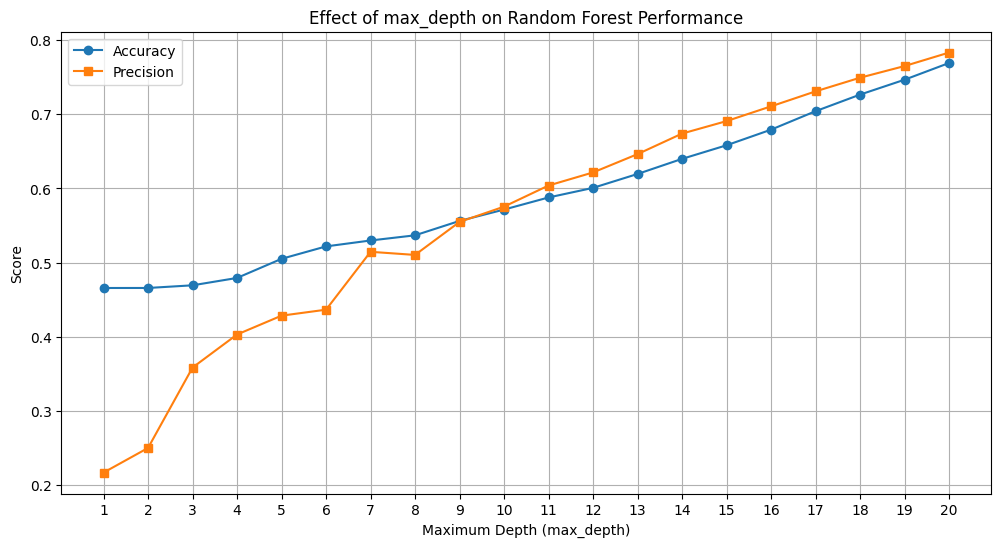

In [7]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X_duplicated_lines, y_duplicated_lines, test_size=0.2, random_state=42, stratify=y_duplicated_lines)

# Prepare to store results
max_depth_range = range(1, 21)  # Testing depths from 1 to 20
accuracy_results_depth = []
precision_results_depth = []

# Loop over the different values of max_depth
for max_depth in max_depth_range:
    # Initialize and fit the Random Forest model
    model = RandomForestClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Append results
    accuracy_results_depth.append(accuracy)
    precision_results_depth.append(precision)

# Plot the results for max_depth
plt.figure(figsize=(12, 6))
plt.plot(max_depth_range, accuracy_results_depth, label='Accuracy', marker='o')
plt.plot(max_depth_range, precision_results_depth, label='Precision', marker='s')
plt.title('Effect of max_depth on Random Forest Performance')
plt.xlabel('Maximum Depth (max_depth)')
plt.ylabel('Score')
plt.xticks(max_depth_range)
plt.legend()
plt.grid()
plt.show()


Let's take a look at higher value cause we haven't reached a constant for the score.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


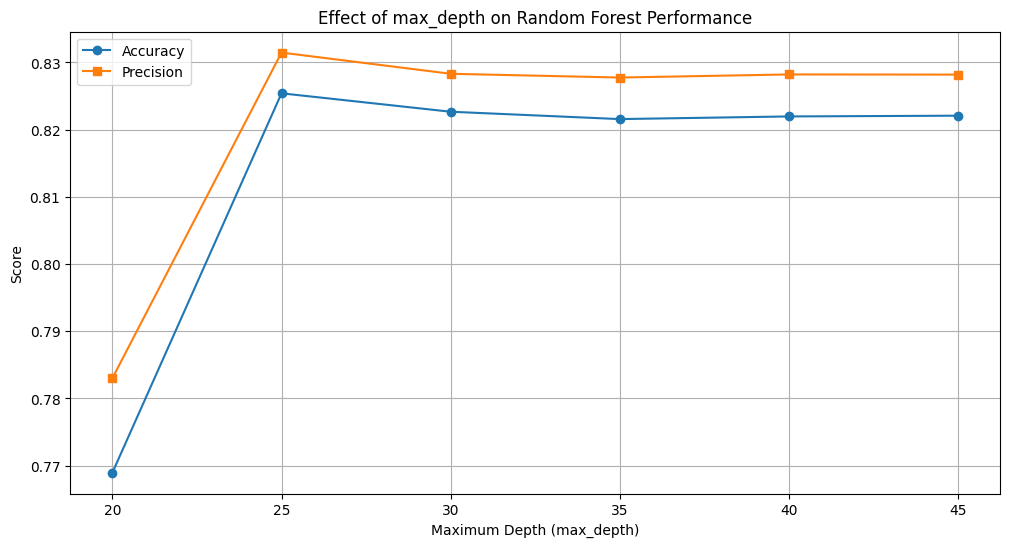

In [9]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X_duplicated_lines, y_duplicated_lines, test_size=0.2, random_state=42, stratify=y_duplicated_lines)

# Prepare to store results
max_depth_range = range(20, 50, 5)  # Testing depths from 20 to 50
accuracy_results_depth = []
precision_results_depth = []

# Loop over the different values of max_depth
for max_depth in max_depth_range:
    # Initialize and fit the Random Forest model
    model = RandomForestClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Append results
    accuracy_results_depth.append(accuracy)
    precision_results_depth.append(precision)

# Plot the results for max_depth
plt.figure(figsize=(12, 6))
plt.plot(max_depth_range, accuracy_results_depth, label='Accuracy', marker='o')
plt.plot(max_depth_range, precision_results_depth, label='Precision', marker='s')
plt.title('Effect of max_depth on Random Forest Performance')
plt.xlabel('Maximum Depth (max_depth)')
plt.ylabel('Score')
plt.xticks(max_depth_range)
plt.legend()
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

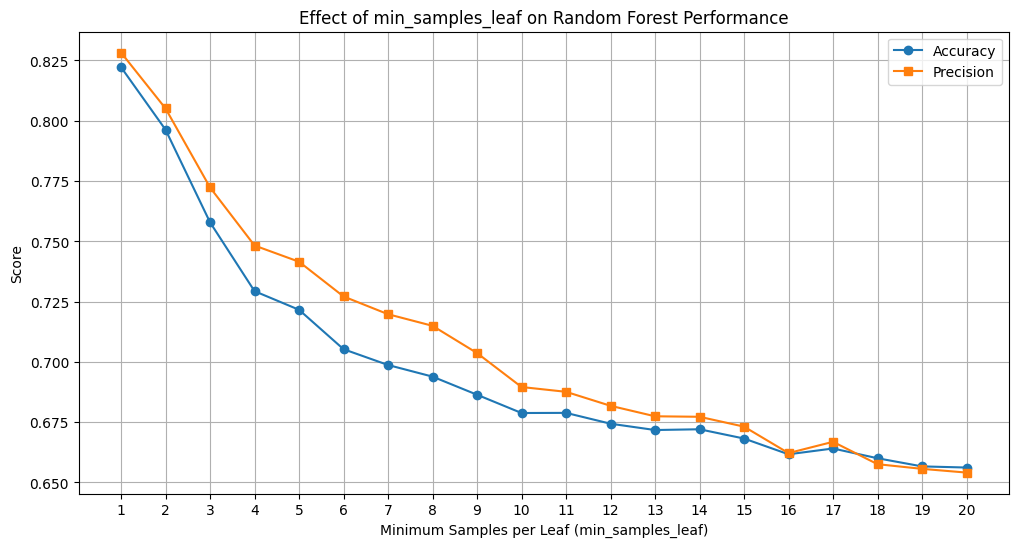

In [8]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X_duplicated_lines, y_duplicated_lines, test_size=0.2, random_state=42, stratify=y_duplicated_lines)

# Prepare to store results
min_samples_leaf_range = range(1, 21)  # Testing leaf sizes from 1 to 20
accuracy_results_leaf = []
precision_results_leaf = []

# Loop over the different values of min_samples_leaf
for min_samples_leaf in min_samples_leaf_range:
    # Initialize and fit the Random Forest model
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Append results
    accuracy_results_leaf.append(accuracy)
    precision_results_leaf.append(precision)

# Plot the results for min_samples_leaf
plt.figure(figsize=(12, 6))
plt.plot(min_samples_leaf_range, accuracy_results_leaf, label='Accuracy', marker='o')
plt.plot(min_samples_leaf_range, precision_results_leaf, label='Precision', marker='s')
plt.title('Effect of min_samples_leaf on Random Forest Performance')
plt.xlabel('Minimum Samples per Leaf (min_samples_leaf)')
plt.ylabel('Score')
plt.xticks(min_samples_leaf_range)
plt.legend()
plt.grid()
plt.show()


### The values we'll select after this grid search are:

Minimum_samples_leaf = 1 <br>
Max_depth = 25 <br>
n_estimators = 150

### 5. Analyse des résultats :

Après avoir ajusté les poids des classes et optimisé les hyperparamètres du modèle, nous avons observé des améliorations notables dans la performance de la Random Forest. En particulier, l'application de poids plus élevés aux classes sous-représentées a permis d'augmenter la précision globale du modèle et de mieux équilibrer les performances pour les différentes classes, notamment celles allant de 2 à 9.

Lors du fine-tuning des hyperparamètres avec GridSearch, nous avons identifié les valeurs optimales pour n_estimators, max_depth, et min_samples_leaf qui ont permis de maximiser la précision tout en évitant le sur-apprentissage. Ces paramètres ont fourni un compromis efficace entre la performance et la complexité du modèle, réduisant ainsi l'overfitting tout en maintenant une bonne capacité de généralisation.

Faisons un dernier run et évaluation de la random forest avec les hyperparamètres et la distribution de poids choisies.

In [11]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and fit the Random Forest model
model1 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=25, min_samples_leaf=1)
model1.fit(X_train, y_train)

# Optional: Check the representation of each hand class in the training set
print("Number of samples per class in the training set:")
print(y_train.value_counts())

y_pred = model1.predict(X_test)
print(f"Accuracy: {model1.score(X_test, y_test)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

Training set class distribution:
0
0    0.465680
1    0.392549
2    0.088493
3    0.039248
4    0.007219
5    0.003709
6    0.002646
7    0.000427
8    0.000022
9    0.000006
Name: proportion, dtype: float64
Number of samples per class in the training set:
0
0    400966
1    337998
2     76195
3     33794
4      6216
5      3194
6      2278
7       368
8        19
9         5
Name: count, dtype: int64
Accuracy: 0.8254056740949275
              precision    recall  f1-score   support

           0       0.79      0.92      0.85    100242
           1       0.82      0.71      0.76     84500
           2       0.97      0.82      0.89     19049
           3       0.99      0.83      0.90      8448
           4       0.99      0.73      0.84      1554
           5       1.00      0.84      0.92       798
           6       1.00      0.75      0.85       570
           7       1.00      0.78      0.88        92
           8       1.00      1.00      1.00         5
           9       1.00  